# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [4]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',   # DATE'i indeks yaptı.
                 parse_dates=True    # type ını datetime a çevirdi
                )

In [5]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [7]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

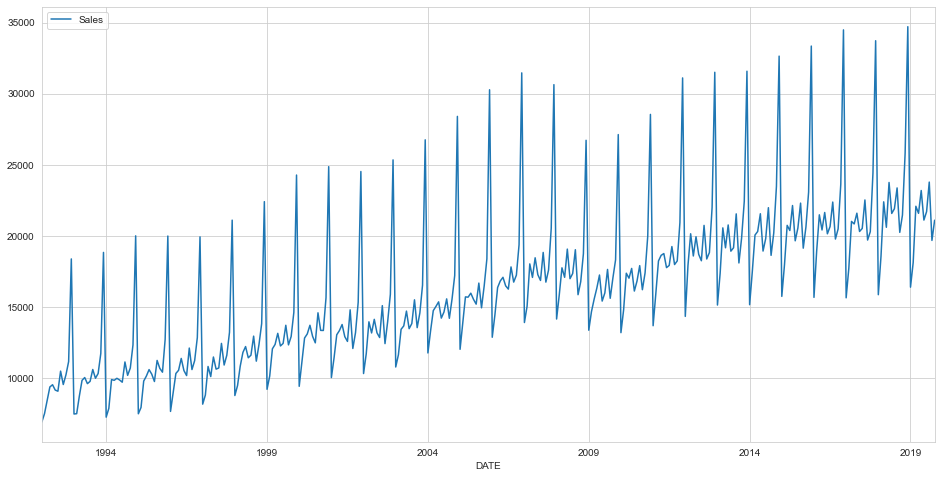

In [8]:
df.plot(figsize=(16,8))

# 25 yıllık veri ama veriler aylık olduğu için 25x12 = 334 data var.

## Preprocessing of Data

### Train Test Split

In [7]:
len(df)

334

In [8]:
len(df)- 18

316

In [9]:
test_size = 18 
# datamdaki saykıl 12 olduğu için bu rakamdan büyük bir test size belirledim.
# test datası ile validation yaparken saykıl olan 12yi bundan çıkarınca geriye 6 kalacak. 6 data ile predict yapacak.

In [10]:
test_ind = len(df)- test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scaling

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [18]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

# generator her defasında 12 lik uzunlukta veri setini alıp 13. veriyi üretiyor.
# dolayısıyla datanın son 12 lik verisinde duruyor. çünkü sonraki adımda elinde 12 veri kalmadığı için.
# bu yüzden datanın uzunluğu -12 (lenght değeri) adet veri üretebiliyor.

In [21]:
generator[0]
# generator modelimin aradığı veri düzenin oluşturdu bana.
# ürettiği ilk eleman ise bu aşağıdaki. 
# bu 12 değerden 13.yü tahmin edecek..

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [23]:
X, y = generator[0]

In [24]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [26]:
n_features = 1

In [29]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))  # tanh (tanjant hiperbolik) seçmedim. bu defa relu seçtim.
model.add(Dense(1))  # 2 değeri karşılaştıracağım için çıkış layer ında 1 nöron olmalı.
model.compile(optimizer = 'adam', loss = 'mse')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [35]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [36]:
len(validation_generator)

# 18-12 = 6 tane 

# son 18 taneyi test için ayırdık, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer üretti. 

6

In [37]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 2s 4ms/step - loss: 0.0252 - val_loss: 0.0124
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0206 - val_loss: 0.0136
Epoch 3/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0139 - val_loss: 0.0016
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 5/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 6/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0022 - val_loss: 0.0110
Epoch 7/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 2.4025e-04
Epoch 9/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 5.

<AxesSubplot:>

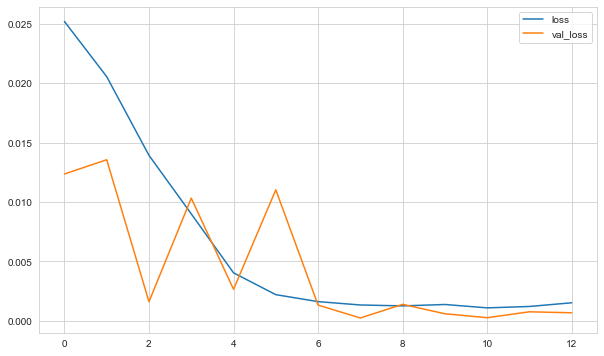

In [38]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [40]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [41]:
y_pred = model.predict(validation_generator)

In [42]:
y_pred

# son 18 taneyi test için ayırıp, bunların içinden stride 1 olacak şekilde 
  # 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 6 tane değer generate etmiştik. 
    # şimdi bu değerlerin predict ini aldık.

array([[0.61374944],
       [0.5446127 ],
       [0.5551044 ],
       [0.6019978 ],
       [0.5025802 ],
       [0.54000896]], dtype=float32)

In [37]:
test_scaled[-6:]

# y_pred i test datamın son 6 sı ile kıyaslamam lazım. çünkü o predict ler onlara denk geliyor

array([[0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

In [43]:
eval_metrics(test_scaled[-6:], y_pred)

r2_score: 0.7267049404137886 
 mae: 0.024381422136122793 
 mse: 0.0006777284558828065 
 rmse: 0.026033218315890307


In [44]:
test_predictions = []

first_eval_batch = train_scaled[-length:]

current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    
# train datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. bundan ileriye forecast yapacağız
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp test_prediction a kaydettim. 

In [46]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.9022445975063257 
 mae: 0.030641482888884748 
 mse: 0.0017231474694396247 
 rmse: 0.0415108114765253


### Inverse Transformations and Comparing

In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

In [44]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21827.687
2018-06-01,21589,20672.805
2018-07-01,21919,20878.435
2018-08-01,23381,22702.336
2018-09-01,20260,20252.465
2018-10-01,21473,20826.481
2018-11-01,25831,24813.760
2018-12-01,34706,34469.329
2019-01-01,16410,16544.659


<AxesSubplot:xlabel='DATE'>

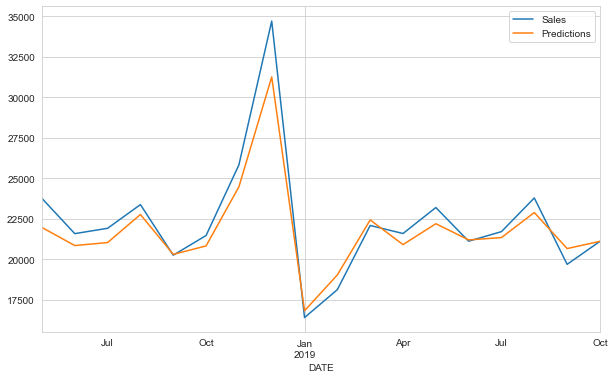

In [49]:
test.plot()

In [50]:
eval_metrics(test.Sales, test.Predictions)

r2_score: 0.9022445975063255 
 mae: 843.9890046914427 
 mse: 1307303.6266532636 
 rmse: 1143.3737913094142


## Retrain and Forecasting

In [73]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [74]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [53]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 2s 4ms/step - loss: 0.0263
Epoch 2/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0153
Epoch 3/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0131
Epoch 4/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 5/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0040
Epoch 6/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0018
Epoch 7/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 8/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 9/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 10/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0015
Epoch 11/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 12/15
322/322 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 13/15
322/322 [====

In [75]:
scaled_full_data.shape

(334, 1)

In [76]:
scaled_full_data[-length:].shape

(12, 1)

In [77]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:] 
# tüm datamın son 12 ye 1 lik kısmını aldım. artık bunu ileriye doğru predict te (forecast) kullanıcam
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)
    
# Burada tüm datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. 
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp forecast e kaydettim. 

In [78]:
forecast = scaler.inverse_transform(forecast)

In [80]:
forecast

array([[26042.80731916],
       [36796.84170532],
       [17638.52728009],
       [19105.83917999],
       [22310.90851259],
       [21858.074368  ],
       [23368.11035776],
       [21534.87118816],
       [22097.38246393],
       [24013.6088295 ],
       [20579.5440557 ],
       [21735.55382395]])

In [82]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [83]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [84]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [85]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

# forecast lerden dataframe oluşturduk

In [86]:
forecast_df

,Forecast
2019-11-01,26042.807
2019-12-01,36796.842
2020-01-01,17638.527
2020-02-01,19105.839
2020-03-01,22310.909
2020-04-01,21858.074
2020-05-01,23368.110
2020-06-01,21534.871
2020-07-01,22097.382
2020-08-01,24013.609


<AxesSubplot:>

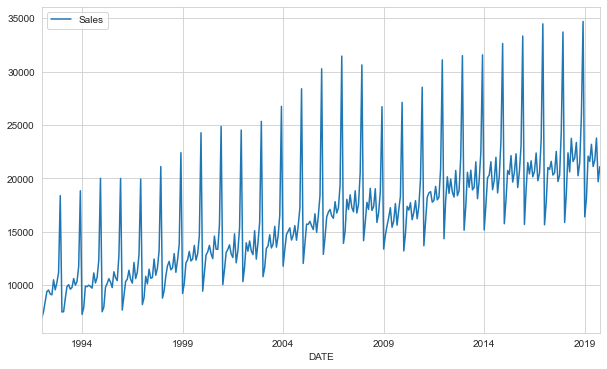

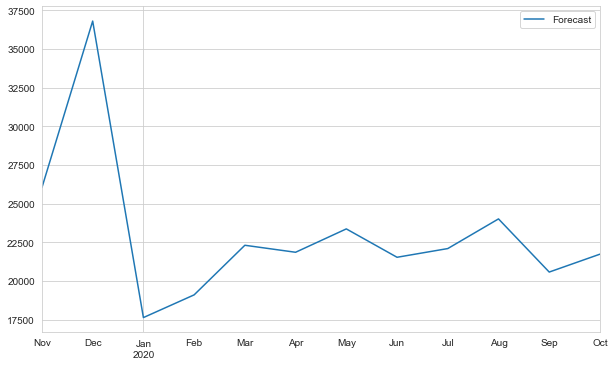

In [87]:
df.plot()
forecast_df.plot()

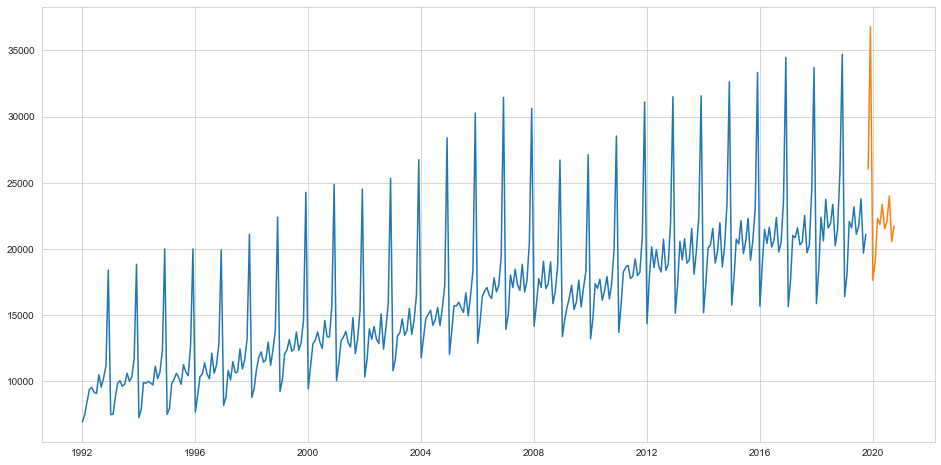

In [88]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

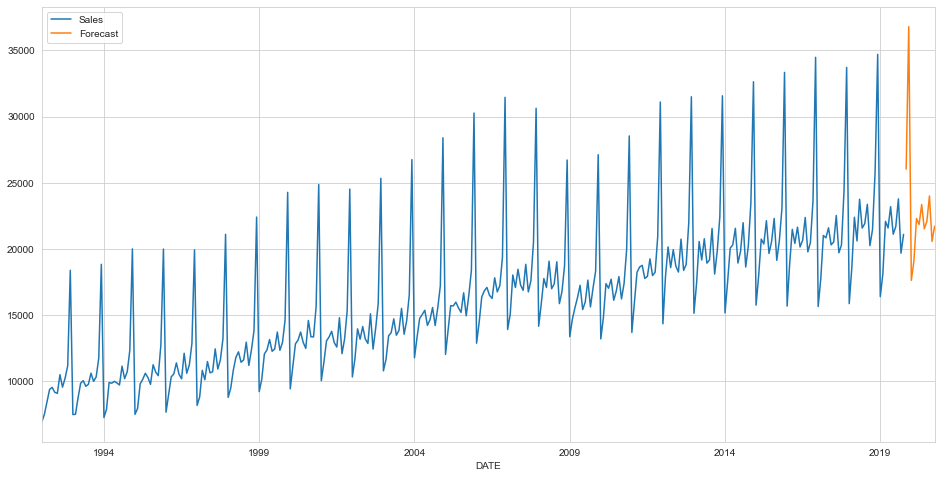

In [89]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

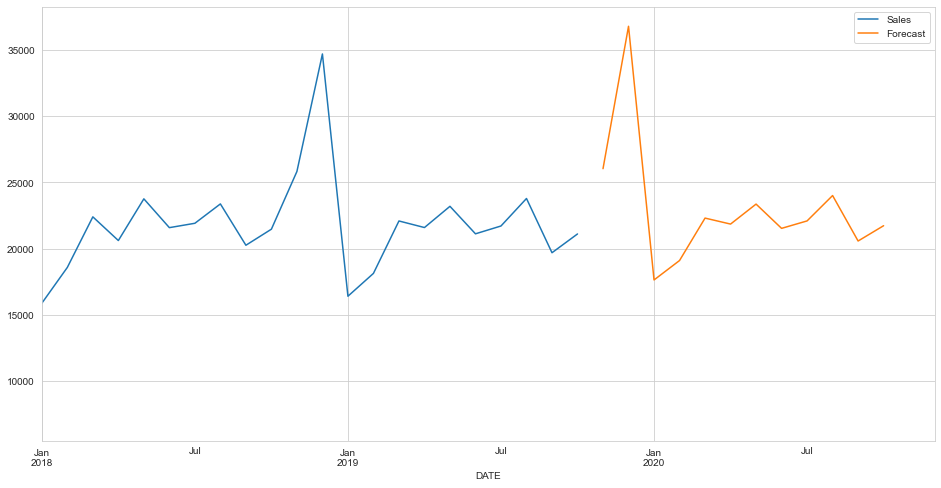

In [90]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')